<a href="https://colab.research.google.com/github/ChiaraBozz/Machine-Learning-project---Pokemon/blob/main/Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### SETUP DATA

In [ ]:
!git clone https://github.com/ChiaraBozz/Machine-Learning-project---Pokemon/

Cloning into 'Machine-Learning-project---Pokemon'...
remote: Enumerating objects: 1499, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (180/180), done.
remote: Total 1499 (delta 13), reused 163 (delta 2), pack-reused 1317
Receiving objects: 100% (1499/1499), 161.42 MiB | 32.47 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [ ]:
!mv Machine-Learning-project---Pokemon/images /content/
!mv Machine-Learning-project---Pokemon/pokemon.csv /content/
!mv Machine-Learning-project---Pokemon/utils.py /content/
!rm -r Machine-Learning-project---Pokemon/

## Pokemon's type detection

### SETUP

In [ ]:
import numpy as np
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
from PIL import Image
import os

from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import colorsys
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import random
from sklearn.multiclass import OneVsRestClassifier

# Set the random seed for PyTorch
torch.manual_seed(0)
# Set the random seed for Python's built-in random module
random.seed(0)
# Set the random seed for NumPy
np.random.seed(0)

from sklearn.pipeline import Pipeline
RAND_STATE = 0

from utils import PCA_KNN
from utils import KNN_hyperparameter_tuning
from utils import SVM_hyperparameter_tuning

results_all = []

In [ ]:
file_path = 'pokemon.csv'

df = pd.read_csv(file_path)

df = df.drop(df.columns[[0, 5, 6, 7, 8, 9, 11, 12]], axis=1)

pokemon_types = ['normal', 'fire', 'water', 'electric', 'grass', 'ice', 'fighting', 'poison', 'ground', 'flying',
                'psychic', 'bug', 'rock', 'ghost', 'dragon', 'dark', 'steel', 'fairy']  # all the pokemon types

####Preliminar data analysis

[154, 80, 171, 81, 111, 44, 52, 50, 52, 13, 115, 122, 69, 46, 46, 54, 46, 102]
          # of pokemon
flying              13
ice                 44
dragon              46
steel               46
ghost               46
poison              50
ground              52
fighting            52
dark                54
rock                69
fire                80
electric            81
fairy              102
grass              111
psychic            115
bug                122
normal             154
water              171


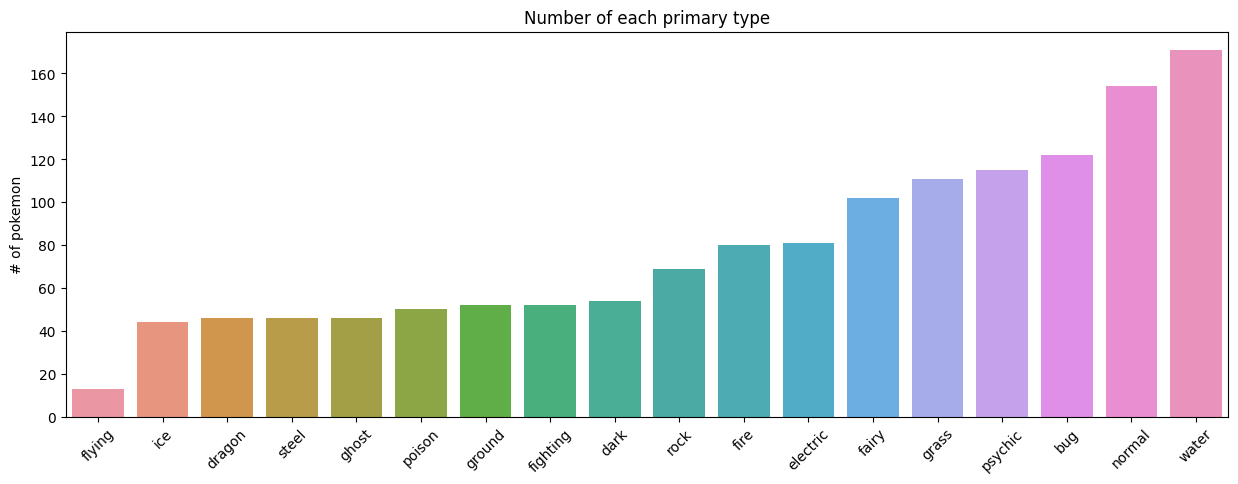

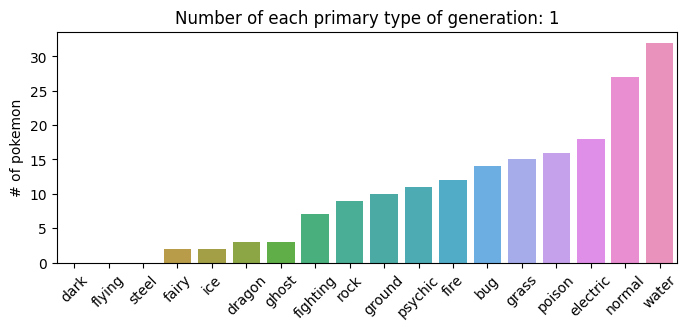

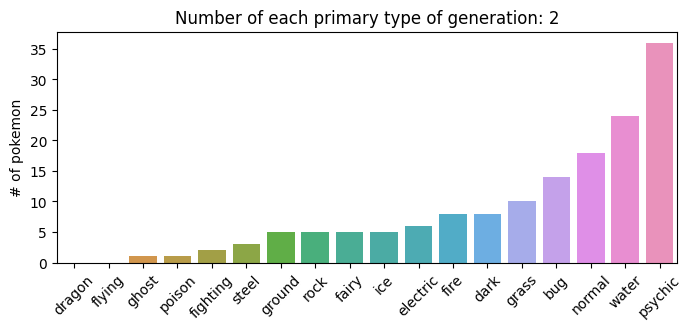

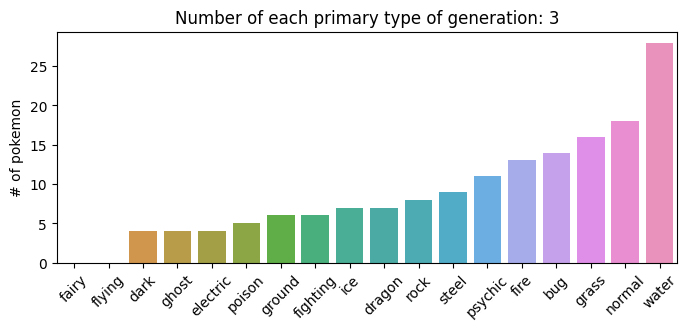

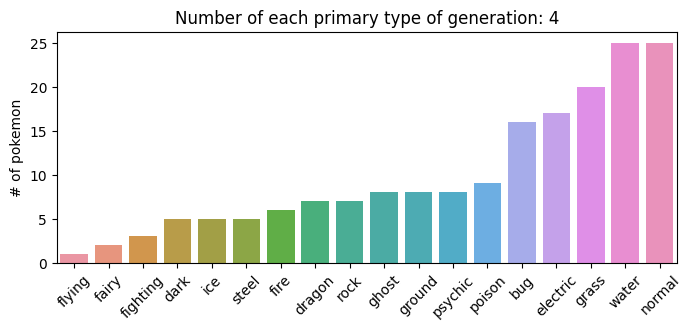

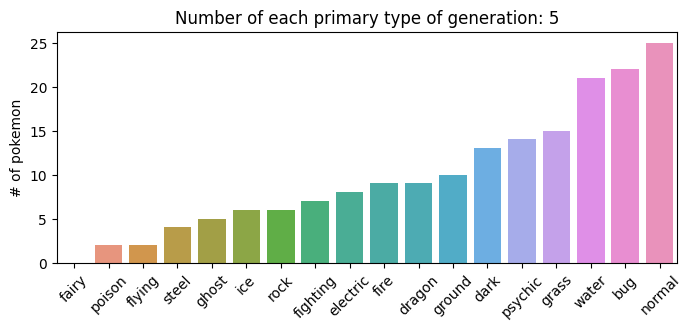

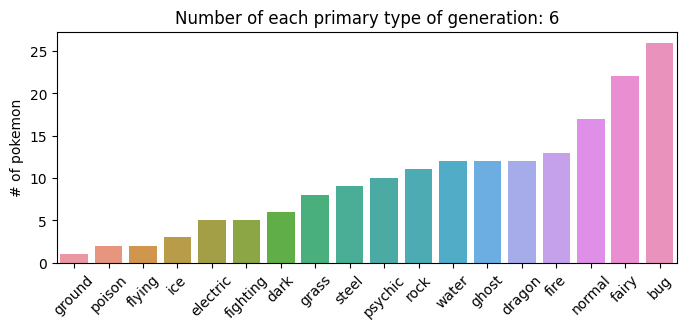

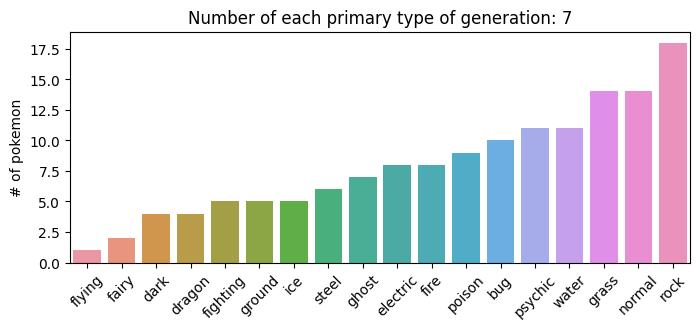

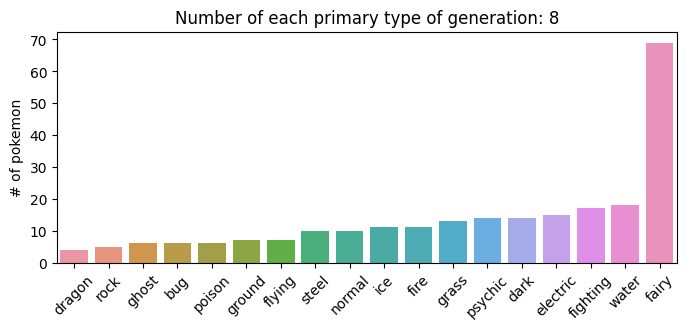

In [ ]:
types_nums = []
for type1 in pokemon_types:
    #print(type1)
    #print(dataframe)
    types_nums.append(sum(df['type1']==type1))
print(types_nums)
type_data = pd.DataFrame(data=types_nums, index=pokemon_types, columns=['# of pokemon'])

type_data = type_data.sort_values(by='# of pokemon')
print(type_data)

# plot number of each type of pokemon
plt.figure(figsize=(15,5))
plt.title('Number of each primary type')
ax = sns.barplot(x=type_data.index, y='# of pokemon', data=type_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

for i in range(1, 9):
  gen = df[df['generation'] == i]
  types_nums = []
  for type1 in pokemon_types:
    #print(type1)
    #print(dataframe)
    types_nums.append(sum(gen['type1']==type1))
  type_data = pd.DataFrame(data=types_nums, index=pokemon_types, columns=['# of pokemon'])

  type_data = type_data.sort_values(by='# of pokemon')

  plt.figure(figsize=(8,3))
  plt.title('Number of each primary type of generation: {}'.format(i))
  ax = sns.barplot(x=type_data.index, y='# of pokemon', data=type_data)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
  plt.show()

From these graphs, we can observed the unbalanced nature of the dataset.

Let's see how is the behaviour from the 1st to the 5th generation.

[113, 48, 130, 53, 76, 25, 25, 33, 39, 3, 80, 80, 35, 21, 26, 30, 21, 9]
          # of pokemon
flying               3
fairy                9
ghost               21
steel               21
ice                 25
fighting            25
dragon              26
dark                30
poison              33
rock                35
ground              39
fire                48
electric            53
grass               76
bug                 80
psychic             80
normal             113
water              130


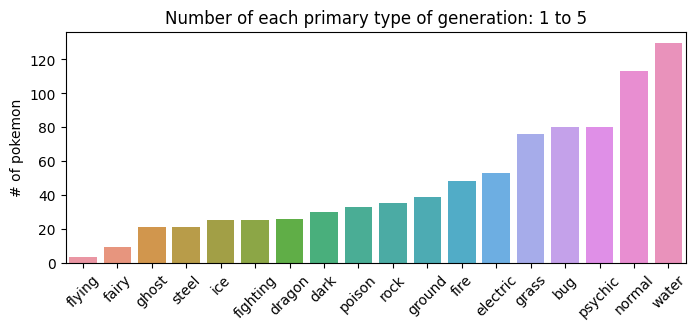

In [ ]:
total_types_nums = [0]*len(pokemon_types)
for i in range(1, 6):
  gen = df[df['generation'] == i]
  types_nums = []
  for type1 in pokemon_types:
    types_nums.append(sum(gen['type1']==type1))

  total_types_nums = [x + y for x, y in zip(total_types_nums, types_nums)]

print(total_types_nums)
type_data = pd.DataFrame(data=total_types_nums, index=pokemon_types, columns=['# of pokemon'])

type_data = type_data.sort_values(by='# of pokemon')
print(type_data)

plt.figure(figsize=(8,3))
plt.title('Number of each primary type of generation: 1 to 5')
ax = sns.barplot(x=type_data.index, y='# of pokemon', data=type_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="center")
plt.show()

Based on the graph, it is evident that the dataset contains a limited number of flying-type Pokémon, with only 3 instances available. This scarcity of data points poses a challenge in training a reliable model for accurately identifying flying-type Pokémon.

Due to the limited availability of some type Pokémon in the dataset, the scope of the identified types will be restricted to a subset.

#### Types and generation selection

In [ ]:
# subset of pokemon types which we want to detect
types = ['water', 'normal', 'bug', 'psychic', 'grass', 'electric', 'fire']

types_len = len(types)

# build the dictionary of the types
TYPES_DICT = {}
i = 0
for el in types:
  TYPES_DICT[el] = i
  i = i + 1
print(TYPES_DICT)

print(df)

# Remove the pokemon with the type, we don't want to detect
types_to_remove = list(set(pokemon_types) - set(types))
for i in types_to_remove:
  df = df.drop(df[df["type1"] == i].index)

print(df)

for i in range(1, 9):
  gen = df[df['generation'] == i]
  gen.to_csv('pokemon_gen_%i.csv' %i, index=False)

# Our train and test set will be composed of pokemon from the 1st to the 5th generation
set_csv = ['pokemon_gen_1.csv', 'pokemon_gen_2.csv', 'pokemon_gen_3.csv', 'pokemon_gen_4.csv', 'pokemon_gen_5.csv']

{'water': 0, 'normal': 1, 'bug': 2, 'psychic': 3, 'grass': 4, 'electric': 5, 'fire': 6}
      nat_dex                name     type1   type2  generation
0           1           bulbasaur     grass  poison           1
1           2             ivysaur     grass  poison           1
2           3            venusaur     grass  poison           1
3           3     venusaur_female     grass  poison           1
4           3       venusaur_gmax     grass  poison           8
...       ...                 ...       ...     ...         ...
1403      902  basculegion_female     water   ghost           8
1404      903            sneasler  fighting  poison           8
1405      904            overqwil      dark  poison           8
1406      905            enamorus     fairy  flying           8
1407      905    enamorus_therian     fairy  flying           8

[1408 rows x 5 columns]
      nat_dex                name    type1    type2  generation
0           1           bulbasaur    grass   poison    

In [ ]:
list_labels = TYPES_DICT.keys()
list_labels

dict_keys(['water', 'normal', 'bug', 'psychic', 'grass', 'electric', 'fire'])

In [ ]:
types_to_remove

['poison',
 'flying',
 'ghost',
 'fighting',
 'dark',
 'steel',
 'rock',
 'ice',
 'dragon',
 'ground',
 'fairy']

### Data Preprocessing
Our **labels** are the pokemon's **types**.

Our **data** are the pokemon's **images** which will be:
  
- Gray Scale

- Coloured

In [ ]:
types_all = []
names = []
for el in set_csv:
  tip = pd.read_csv(el)
  types_all = types_all + (tip["type1"].tolist())
  names = names + tip["name"].tolist()

print(types_all)
print(len(types_all))

print(names)
print(len(names))

# Convert type(string) to number
labels = []
print(TYPES_DICT)
for el in types_all:
  labels.append(TYPES_DICT[el])

print(labels)
labels = np.array(labels)

['grass', 'grass', 'grass', 'grass', 'fire', 'fire', 'fire', 'water', 'water', 'water', 'bug', 'bug', 'bug', 'bug', 'bug', 'bug', 'bug', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'normal', 'electric', 'electric', 'electric', 'electric', 'electric', 'electric', 'electric', 'electric', 'electric', 'electric', 'electric', 'fire', 'fire', 'normal', 'normal', 'grass', 'grass', 'grass', 'grass', 'grass', 'bug', 'bug', 'bug', 'bug', 'normal', 'normal', 'water', 'water', 'fire', 'fire', 'water', 'water', 'water', 'psychic', 'psychic', 'psychic', 'psychic', 'psychic', 'grass', 'grass', 'grass', 'water', 'water', 'fire', 'fire', 'water', 'water', 'electric', 'electric', 'normal', 'normal', 'normal', 'normal', 'normal', 'water', 'water', 'water', 'water', 'psychic', 'psychic', 'psychic', 'water', 'water', 'electric', 'electric', 'grass', 'grass', 'normal', 'normal', 'grass', 'normal', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'water', 'ps

In [ ]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
images = []
images_bw = []
images_hsv_histo = []

import cv2

for el in names:
  filename = el + ".png"
  directory = "images"

  if os.path.isfile(os.path.join(directory, filename)):
    #print(filename)
    image = Image.open(os.path.join(directory, filename))
    image = image.resize((50, 50))

  ## Gray-scale
    gray_images = image.convert("L")
    images_bw.append(np.array(gray_images).flatten())

  ## Coloured
    image_array = np.array(image)
    images.append(image_array)

  ## HSV histograms
    image = cv2.imread(os.path.join(directory, filename))
    image = cv2.resize(image, (50, 50))
    # Convert the image to the HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Split the image into separate channels
    h, s, v = cv2.split(hsv_image)
    # Calculate the histograms for each channel
    hist_h = cv2.calcHist([h], [0], None, [256], [0, 256]).flatten()
    hist_s = cv2.calcHist([s], [0], None, [256], [0, 256]).flatten()
    hist_v = cv2.calcHist([v], [0], None, [256], [0, 256]).flatten()
    # Concatenate the histograms into a single feature vector
    histo = np.concatenate((hist_h, hist_s, hist_v))
    images_hsv_histo.append(histo)

images_bw_np = np.array(images_bw)
images_np = np.array(images)

images_hsv_histo_np = np.array(images_hsv_histo)

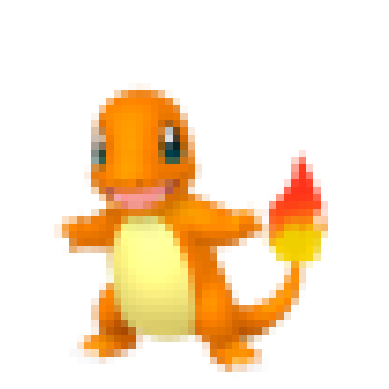

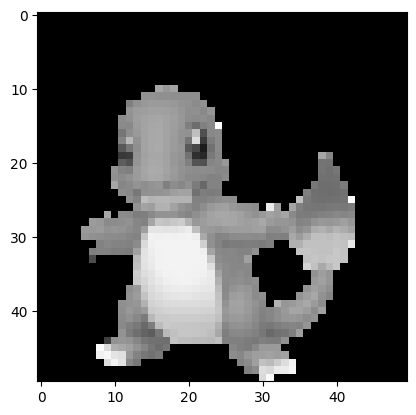

In [ ]:
#print(images)
for image in images[4:5]:
  plt.imshow(image)  # Use 'gray' colormap for grayscale images
  plt.axis('off')  # Turn off the axis
  plt.show()

for image in images_bw[4:5]:
  image = image.reshape(50,50)
  plt.imshow(image, cmap='gray')
  plt.show()

In [ ]:
# print(len(images))
# # see that the names correspond with the pokemon
# for i in range(len(images)):
#   print(names[i])
#   plt.imshow(images[i])  # Use 'gray' colormap for grayscale images
#   plt.axis('off')  # Turn off the axis
#   plt.show()

### B/W

#### Data splitting

In [ ]:
data = images_bw_np
print(data.shape)

(580, 2500)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.33, random_state=42)#, stratify = labels)

train_data, test_data, train_labels, test_labels = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

# Scale (Normalize) the data.
#scaler = MinMaxScaler()                   # x-min / max-min
#scaler = StandardScaler()
#train_data, test_data, train_labels, test_labels = scaler.fit_transform(X_train), scaler.fit_transform(X_test), y_train, y_test

# NB. svm is worse with scaled data

#####Verify it is all okay with the splitting

In [ ]:
# # Verify it is all okay with the splitting
# for i in range(0,5):
#   image = X_train[i].reshape(50,50)

#   poke_type = [key for key, value in TYPES_DICT.items() if value == y_train[i]][0]
#   print("Type:", poke_type)

#   plt.imshow(image, cmap='gray')
#   plt.show()

In [ ]:
print(np.unique(y_train))

from collections import Counter
# Count the occurrences of elements
counts = Counter(y_train)

# Reorder the counts in descending order
ordered_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Print the counts
for element, count in ordered_counts:
    poke_type = [key for key, value in TYPES_DICT.items() if value == element][0]
    print(f"- {poke_type} occurs {count} times")

[0 1 2 3 4 5 6]
- water occurs 95 times
- normal occurs 73 times
- psychic occurs 52 times
- grass occurs 51 times
- bug occurs 50 times
- electric occurs 35 times
- fire occurs 32 times


In [ ]:
print(np.unique(y_test))
# Count the occurrences of elements
counts = Counter(y_test)

# Reorder the counts in descending order
ordered_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Print the counts
for element, count in ordered_counts:
    poke_type = [key for key, value in TYPES_DICT.items() if value == element][0]
    print(f"- {poke_type} occurs {count} times")

[0 1 2 3 4 5 6]
- normal occurs 40 times
- water occurs 35 times
- bug occurs 30 times
- psychic occurs 28 times
- grass occurs 25 times
- electric occurs 18 times
- fire occurs 16 times


####SVM

Hyper parameter tuning in order to find the best parameters for the SVM

In [ ]:
kernels = ["linear", "poly", "rbf", "sigmoid"]
gammas = ["scale", "auto"]

results = []

for kernel in kernels:
  for gamma in gammas:
    #print(kernel + "-" + gamma)

    pseudo_classifier = OneVsRestClassifier(SVC(kernel=kernel, degree=1, C=1, gamma=gamma, probability=True)).fit(train_data, train_labels)

    predictions = pseudo_classifier.predict(test_data)

    acc = round(accuracy_score(test_labels, predictions), 4)
    precision = round(precision_score(test_labels, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels, predictions, average='macro'), 4)
    f1 = f1_score(test_labels, predictions, average='macro')

    results.append({'Kernel': kernel, 'Gamma': gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

svm_df = pd.DataFrame(results)
svm_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print(svm_df)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale    0.4635     0.4547  0.4232  0.424689
2     poly  scale    0.4427     0.4182  0.4060  0.403570
0   linear  scale    0.3802     0.3603  0.3598  0.359802
1   linear   auto    0.3802     0.3603  0.3598  0.359802
3     poly   auto    0.3802     0.3603  0.3598  0.359802
6  sigmoid  scale    0.2083     0.2052  0.1903  0.184104
5      rbf   auto    0.1875     0.8833  0.1518  0.061055
7  sigmoid   auto    0.0833     0.8690  0.1429  0.021978


In [ ]:
best_row_index = svm_df['Accuracy'].idxmax()

best_kernel = svm_df.loc[best_row_index, 'Kernel']
best_gamma = svm_df.loc[best_row_index, 'Gamma']

print(best_kernel, best_gamma)

rbf scale


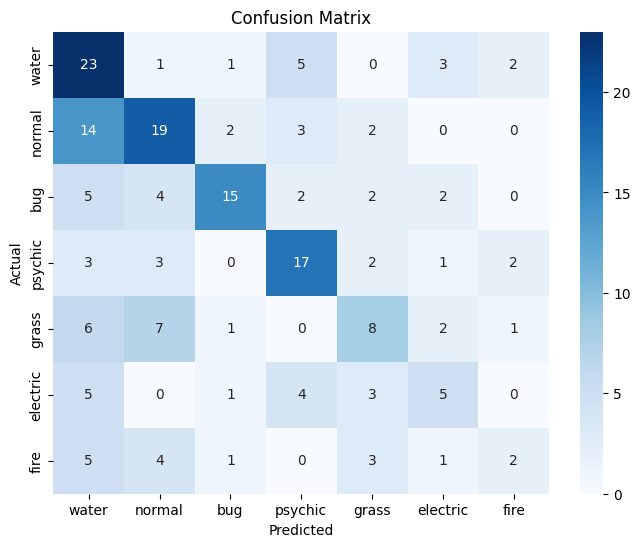

Fully supervised results: Accuracy 0.4635, Precision 0.4547, Recall 0.4232


In [ ]:
pseudo_classifier = OneVsRestClassifier(SVC(kernel=best_kernel, degree=1, C=1, gamma=best_gamma, probability=True)).fit(train_data, train_labels)
predictions = pseudo_classifier.predict(test_data)

cm = confusion_matrix(test_labels, predictions)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_labels, yticklabels=list_labels)

# Customize plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show plot
plt.show()

acc = round(accuracy_score(test_labels, predictions), 4)
precision = round(precision_score(test_labels, predictions, average='macro'), 4)
recall = round(recall_score(test_labels, predictions, average='macro'), 4)
f1 = f1_score(test_labels, predictions, average='macro')
print('Fully supervised results: Accuracy {}, Precision {}, Recall {}'.format(acc, precision, recall))

results_all.append({'Pipeline': "BW-SVM", 'Kernel': best_kernel, 'Gamma': best_gamma, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

####K-NN

#####K-NN HYPER PARAMETER TUNING

In [ ]:
from itertools import product
import math
n_neighbors = [3, 5, 7, 9, 11, round(math.sqrt(train_data.shape[0]))]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'cosine', 'chebyshev', 'minkowski']

results = []

for n, w, m in product(n_neighbors, weights, metric):
    # Create the KNN classifier with the current hyperparameters
    knn = KNeighborsClassifier(n_neighbors=n, weights=w, metric=m)
    # Fit the model to the training data
    knn.fit(train_data, train_labels)
    # Make predictions on the test data
    predictions = knn.predict(test_data)

    acc = round(accuracy_score(test_labels, predictions), 4)
    precision = round(precision_score(test_labels, predictions, average='macro', zero_division=1), 4)
    recall = round(recall_score(test_labels, predictions, average='macro'), 4)
    f1 = f1_score(test_labels, predictions, average='macro')

    results.append({'n_neighbors': n, 'weights': w, 'metric' : m, 'Accuracy': acc, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

In [ ]:
knn_df = pd.DataFrame(results)
knn_df.sort_values(by='Accuracy', ascending=False, inplace=True)

print(knn_df)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
6             3  distance  manhattan    0.4427     0.4572  0.4299  0.430164
16            5  distance  manhattan    0.4375     0.4514  0.4149  0.417980
56           20  distance  manhattan    0.4271     0.4931  0.3978  0.402411
46           11  distance  manhattan    0.4219     0.4449  0.3953  0.396283
36            9  distance  manhattan    0.4219     0.4200  0.3967  0.399797
29            7  distance  minkowski    0.4167     0.4838  0.4059  0.402207
26            7  distance  manhattan    0.4167     0.4125  0.3908  0.390595
25            7  distance  euclidean    0.4167     0.4838  0.4059  0.402207
19            5  distance  minkowski    0.4010     0.4771  0.3908  0.389204
15            5  distance  euclidean    0.4010     0.4771  0.3908  0.389204
37            9  distance     cosine    0.3906     0.5304  0.3663  0.394553
57           20  distance     cosine    0.3854     0.5674  0.3543  0.387086
47          

In [ ]:
best_row_index = knn_df['Accuracy'].idxmax()

best_n_neighbors = knn_df.loc[best_row_index, 'n_neighbors']
best_weights = knn_df.loc[best_row_index, 'weights']
best_metric = knn_df.loc[best_row_index, 'metric']

print(best_n_neighbors, best_weights, best_metric)

3 distance manhattan


#####K-NN with best parameters

Accuracy: 0.4427083333333333


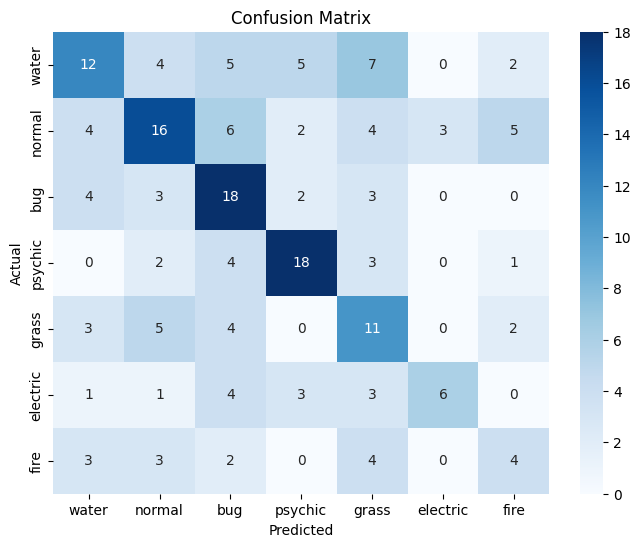

In [ ]:
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights=best_weights, metric=best_metric)
knn.fit(train_data, train_labels)
y_pred = knn.predict(test_data)

accuracy = accuracy_score(test_labels, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(test_labels, y_pred)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list_labels, yticklabels=list_labels)

# Customize plot
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Show plot
plt.show()

results_all.append({'Pipeline': "BW-KNN", 'n_neighbors': best_n_neighbors, 'weights': best_weights, 'metric' : best_metric, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1})

####PCA

#####PCA Variance threshold

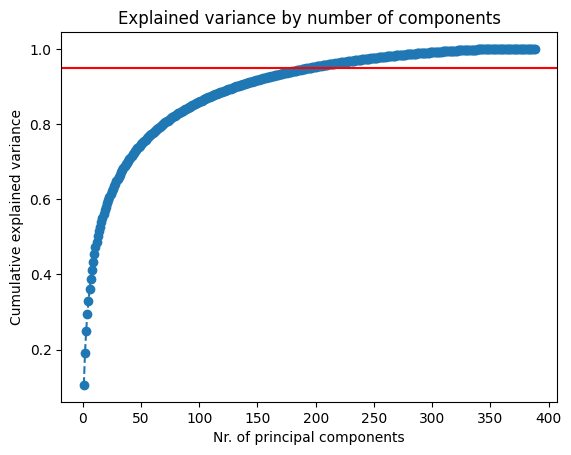

In [ ]:
# Scale (Normalize) the data.
scaler = MinMaxScaler()                   # x-min / max-min
scaled_train_data = scaler.fit_transform(train_data)  # Data here become a np array, it's no longer a dataframe.

# Apply PCA without specifying the number of components to keep, in order to understand how many PCs are sufficient.
pca = PCA(random_state=RAND_STATE)
pca.fit(scaled_train_data)

# Plot the explained variance ratio in a cumulative fashion, in order to visualize the cumulative variance plot.
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()


In [ ]:
n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]
print(n_comp)

195


Perform PCA on train data and test data

In [ ]:
# Use the number of components needed to explain more than 95% of the variance in order to create a new PCA object and
# perform the final dimensionality reduction on the data.
pca = PCA(n_components=n_comp, random_state=RAND_STATE)
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data)
pca_test_data = pca.transform(scaled_test_data)

#####PCA + KNN

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
15            5  distance  euclidean    0.4271     0.4901  0.4101  0.408562
19            5  distance  minkowski    0.4271     0.4901  0.4101  0.408562
8             3  distance  chebyshev    0.4115     0.4134  0.3969  0.395600
28            7  distance  chebyshev    0.4115     0.4454  0.3890  0.397432
25            7  distance  euclidean    0.4062     0.4747  0.3929  0.392730
38            9  distance  chebyshev    0.4062     0.4458  0.3826  0.388006
17            5  distance     cosine    0.4062     0.4225  0.3883  0.382837
16            5  distance  manhattan    0.4062     0.5092  0.3973  0.379474
29            7  distance  minkowski    0.4062     0.4747  0.3929  0.392730
7             3  distance     cosine    0.4062     0.4156  0.3841  0.383447
48           11  distance  chebyshev    0.4010     0.4285  0.3693  0.373251
57           20  distance     cosine    0.3958     0.4497  0.3740  0.375829
35          

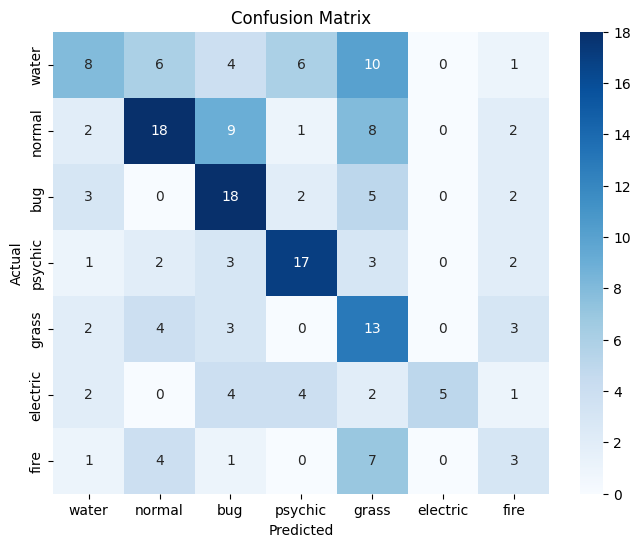

In [ ]:
result = KNN_hyperparameter_tuning(pca_train_data, train_labels, pca_test_data, test_labels, list_labels)

In [ ]:
result["Pipeline"]="BW-PCA-KNN"
results_all.append(result)

#####PCA + SVM

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale    0.4583     0.4860  0.4227  0.423684
5      rbf   auto    0.4427     0.4449  0.4100  0.410230
0   linear  scale    0.4010     0.3776  0.3695  0.371372
1   linear   auto    0.4010     0.3776  0.3695  0.371372
2     poly  scale    0.3646     0.3358  0.3297  0.318345
3     poly   auto    0.3646     0.3358  0.3297  0.318345
7  sigmoid   auto    0.3073     0.2438  0.2666  0.245396
6  sigmoid  scale    0.2708     0.2289  0.2394  0.227890
rbf scale
Fully supervised results: Accuracy 0.4583, Precision 0.486, Recall 0.4227


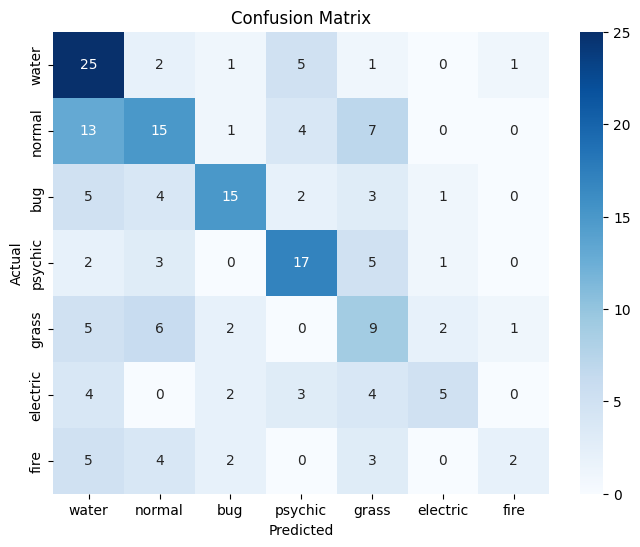

In [ ]:
result = SVM_hyperparameter_tuning(pca_train_data, train_labels, pca_test_data, test_labels, list_labels)

In [ ]:
result["Pipeline"]="BW-PCA-SVM"
results_all.append(result)

In [ ]:
res_df = pd.DataFrame(results_all)

res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)

res_df

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.442708,0.4117,0.3152,0.319431,3.0,distance,manhattan
2,BW-PCA-KNN,NaN,NaN,0.427083,0.4234,0.3368,0.339911,5.0,distance,euclidean
0,BW-SVM,rbf,scale,0.463500,0.4547,0.4232,0.424689,NaN,NaN,NaN
3,BW-PCA-SVM,rbf,scale,0.458300,0.4860,0.4227,0.423684,NaN,NaN,NaN


### COLORED

#### RGB

In [ ]:
print(len(images))

images_np = np.array(images)

print(images_np.shape)

images_np_res = images_np.reshape((len(images), -1))

print(images_np_res.shape)


580
(580, 50, 50, 4)
(580, 10000)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_np_res, labels, test_size=0.33, random_state=42)

train_data, test_data, train_labels, test_labels = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

SVM

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale    0.5365     0.5636  0.4857  0.488807
0   linear  scale    0.4792     0.4625  0.4579  0.457730
1   linear   auto    0.4792     0.4625  0.4579  0.457730
3     poly   auto    0.4792     0.4625  0.4579  0.457730
2     poly  scale    0.4688     0.4825  0.4470  0.441917
6  sigmoid  scale    0.3229     0.3433  0.3128  0.299723
5      rbf   auto    0.1875     0.8833  0.1518  0.061055
7  sigmoid   auto    0.0833     0.8690  0.1429  0.021978
rbf scale
Fully supervised results: Accuracy 0.5365, Precision 0.5636, Recall 0.4857


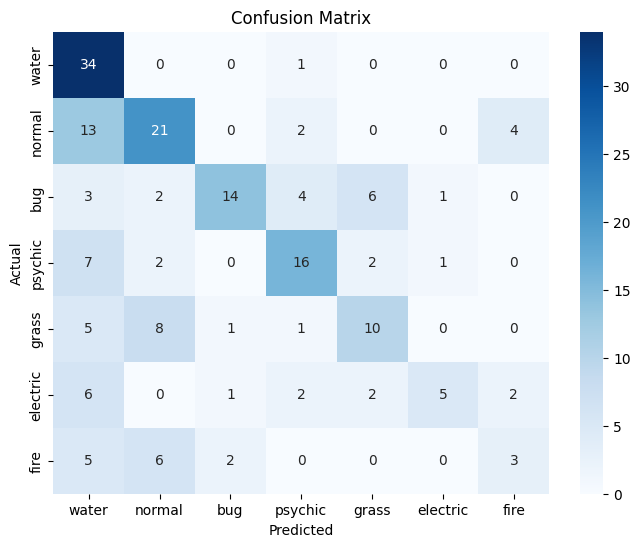

In [ ]:
result = SVM_hyperparameter_tuning(train_data, train_labels, test_data, test_labels, list_labels)

In [ ]:
result["Pipeline"]="RGB-SVM"
results_all.append(result)

KNN

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
36            9  distance  manhattan    0.5000     0.5143  0.4604  0.466009
26            7  distance  manhattan    0.4948     0.5190  0.4607  0.467039
56           20  distance  manhattan    0.4792     0.5592  0.4459  0.460487
29            7  distance  minkowski    0.4792     0.5484  0.4386  0.450139
25            7  distance  euclidean    0.4792     0.5484  0.4386  0.450139
46           11  distance  manhattan    0.4792     0.5211  0.4450  0.455621
39            9  distance  minkowski    0.4479     0.4949  0.4042  0.407501
35            9  distance  euclidean    0.4479     0.4949  0.4042  0.407501
16            5  distance  manhattan    0.4375     0.4473  0.4008  0.406868
5             3  distance  euclidean    0.4375     0.4744  0.4042  0.409098
9             3  distance  minkowski    0.4375     0.4744  0.4042  0.409098
37            9  distance     cosine    0.4323     0.5086  0.3940  0.417808
6           

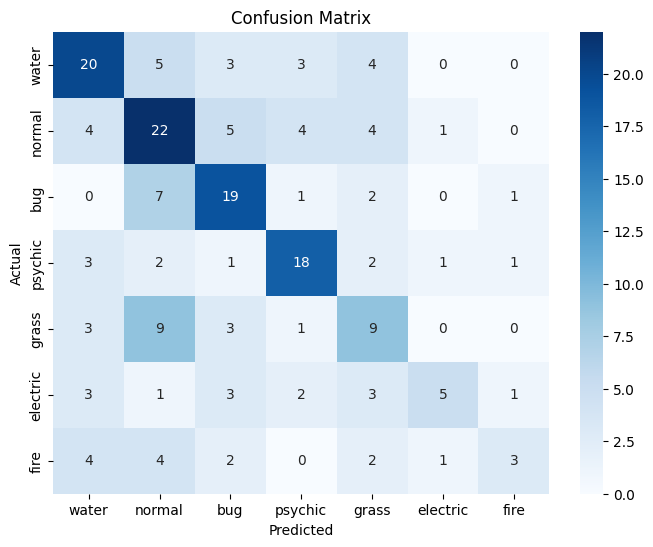

In [ ]:
result = KNN_hyperparameter_tuning(train_data, train_labels, test_data, test_labels, list_labels)

In [ ]:
result["Pipeline"]="RGB-KNN"
results_all.append(result)

PCA

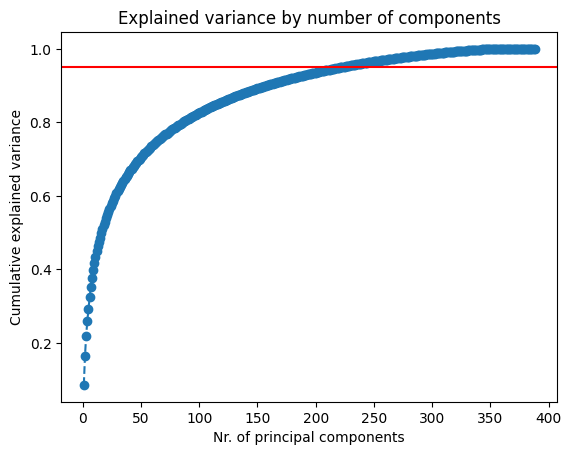

221


In [ ]:
# Scale (Normalize) the data.
scaler = MinMaxScaler()                   # x-min / max-min
scaled_train_data = scaler.fit_transform(train_data)  # Data here become a np array, it's no longer a dataframe.

# Apply PCA without specifying the number of components to keep, in order to understand how many PCs are sufficient.
pca = PCA(random_state=RAND_STATE)
pca.fit(scaled_train_data)

# Plot the explained variance ratio in a cumulative fashion, in order to visualize the cumulative variance plot.
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]
print(n_comp)

In [ ]:
# Use the number of components needed to explain more than 80% of the variance in order to create a new PCA object and
# perform the final dimensionality reduction on the data.
pca = PCA(n_components=n_comp, random_state=RAND_STATE)
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data)
pca_test_data = pca.transform(scaled_test_data)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
35            9  distance  euclidean    0.4688     0.5703  0.4316  0.441053
38            9  distance  chebyshev    0.4688     0.4894  0.4303  0.434117
39            9  distance  minkowski    0.4688     0.5703  0.4316  0.441053
27            7  distance     cosine    0.4635     0.4590  0.4339  0.434571
37            9  distance     cosine    0.4635     0.4475  0.4308  0.425255
49           11  distance  minkowski    0.4583     0.5296  0.4172  0.424569
45           11  distance  euclidean    0.4583     0.5296  0.4172  0.424569
26            7  distance  manhattan    0.4531     0.5840  0.4167  0.412691
36            9  distance  manhattan    0.4479     0.5894  0.4105  0.404224
47           11  distance     cosine    0.4479     0.4420  0.4159  0.413514
58           20  distance  chebyshev    0.4427     0.5539  0.4076  0.416301
57           20  distance     cosine    0.4427     0.4553  0.4091  0.411961
29          

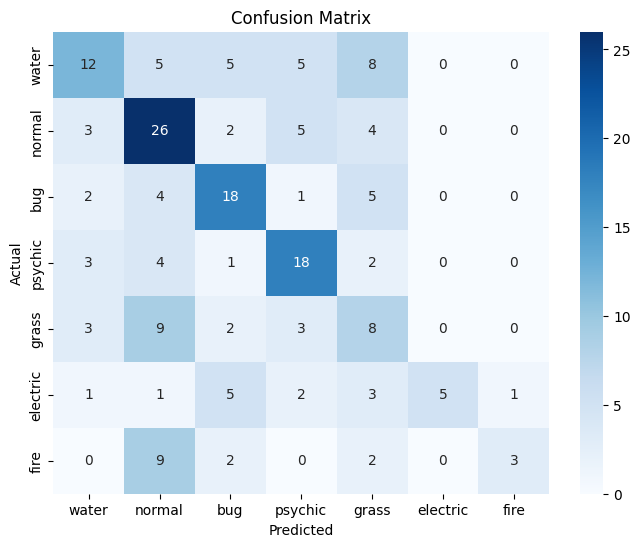

In [ ]:
result = KNN_hyperparameter_tuning(pca_train_data, train_labels, pca_test_data, test_labels, list_labels)
result["Pipeline"]="RGB-PCA-KNN"
results_all.append(result)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale    0.5729     0.5893  0.5221  0.531561
3     poly   auto    0.5208     0.5210  0.4974  0.501758
5      rbf   auto    0.5000     0.6701  0.4503  0.460889
0   linear  scale    0.4792     0.4709  0.4541  0.454640
1   linear   auto    0.4792     0.4709  0.4541  0.454640
2     poly  scale    0.4688     0.4798  0.4401  0.433409
6  sigmoid  scale    0.4219     0.4332  0.4077  0.401859
7  sigmoid   auto    0.2552     0.2136  0.2376  0.218342
rbf scale
Fully supervised results: Accuracy 0.5729, Precision 0.5893, Recall 0.5221


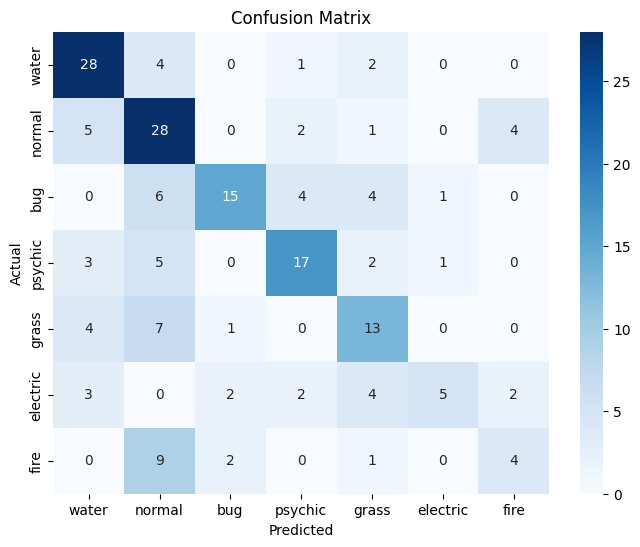

In [ ]:
result = SVM_hyperparameter_tuning(pca_train_data, train_labels, pca_test_data, test_labels, list_labels)

result["Pipeline"]="RGB-PCA-SVM"
results_all.append(result)

In [ ]:
res_df = pd.DataFrame(results_all)
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)
res_df

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.442708,0.4117,0.3152,0.319431,3.0,distance,manhattan
2,BW-PCA-KNN,NaN,NaN,0.427083,0.4234,0.3368,0.339911,5.0,distance,euclidean
5,RGB-KNN,NaN,NaN,0.500000,0.5759,0.3544,0.353682,9.0,distance,manhattan
6,RGB-PCA-KNN,NaN,NaN,0.468750,0.5329,0.3871,0.395919,9.0,distance,euclidean
0,BW-SVM,rbf,scale,0.463500,0.4547,0.4232,0.424689,NaN,NaN,NaN
3,BW-PCA-SVM,rbf,scale,0.458300,0.4860,0.4227,0.423684,NaN,NaN,NaN
4,RGB-SVM,rbf,scale,0.536500,0.5636,0.4857,0.488807,NaN,NaN,NaN
7,RGB-PCA-SVM,rbf,scale,0.572900,0.5893,0.5221,0.531561,NaN,NaN,NaN


#### HSV

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_hsv_histo_np, labels, test_size=0.33, random_state=42)

train_data, test_data, train_labels, test_labels = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

SVM - KNN

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale    0.5573     0.5748  0.5379  0.547890
1   linear   auto    0.5573     0.5748  0.5379  0.547890
3     poly   auto    0.5573     0.5793  0.5396  0.549833
2     poly  scale    0.4792     0.4983  0.4500  0.441065
4      rbf  scale    0.4740     0.5076  0.4480  0.446223
5      rbf   auto    0.3021     0.8867  0.2556  0.243798
6  sigmoid  scale    0.2135     0.4726  0.1957  0.147449
7  sigmoid   auto    0.0833     0.8690  0.1429  0.021978
linear scale
Fully supervised results: Accuracy 0.5573, Precision 0.5748, Recall 0.5379


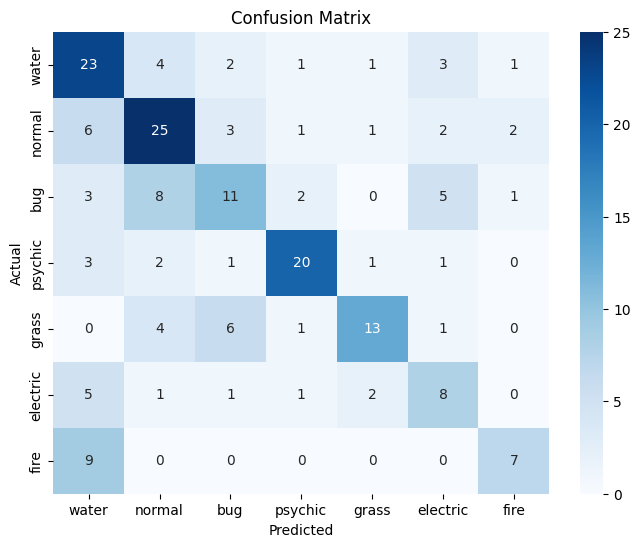

In [ ]:
result = SVM_hyperparameter_tuning(train_data, train_labels, test_data, test_labels, list_labels)

result["Pipeline"]="HSV-SVM"
results_all.append(result)


    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
6             3  distance  manhattan    0.6198     0.6696  0.6025  0.616864
26            7  distance  manhattan    0.5781     0.6241  0.5526  0.567665
36            9  distance  manhattan    0.5469     0.5796  0.5248  0.534519
16            5  distance  manhattan    0.5469     0.6051  0.5229  0.543080
46           11  distance  manhattan    0.5365     0.6009  0.5193  0.536477
47           11  distance     cosine    0.5312     0.5677  0.4924  0.502870
7             3  distance     cosine    0.5312     0.5343  0.4965  0.498373
37            9  distance     cosine    0.5260     0.5411  0.4862  0.493536
57           20  distance     cosine    0.5260     0.5960  0.4818  0.496270
56           20  distance  manhattan    0.5260     0.6097  0.4994  0.522892
17            5  distance     cosine    0.5208     0.5195  0.4859  0.488710
49           11  distance  minkowski    0.5156     0.5482  0.4782  0.492051
45          

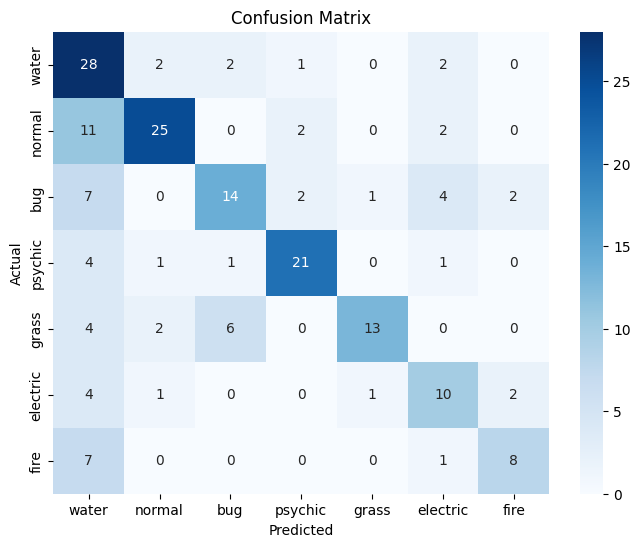

In [ ]:
result = KNN_hyperparameter_tuning(train_data, train_labels, test_data, test_labels, list_labels)

result["Pipeline"]="HSV-KNN"
results_all.append(result)

PCA

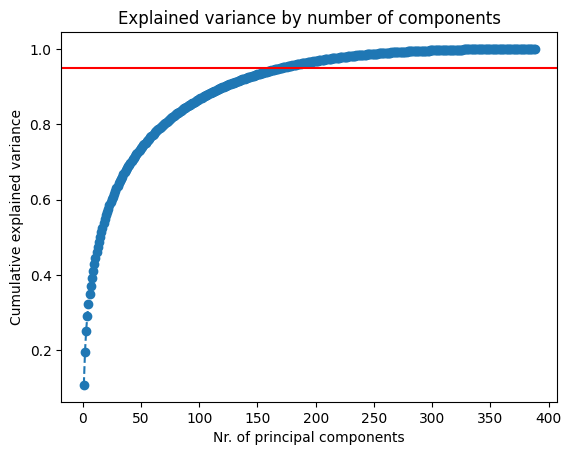

170


In [ ]:
# Scale (Normalize) the data.
scaler = MinMaxScaler()                   # x-min / max-min
scaled_train_data = scaler.fit_transform(train_data)  # Data here become a np array, it's no longer a dataframe.

# Apply PCA without specifying the number of components to keep, in order to understand how many PCs are sufficient.
pca = PCA(random_state=RAND_STATE)
pca.fit(scaled_train_data)

# Plot the explained variance ratio in a cumulative fashion, in order to visualize the cumulative variance plot.
plt.plot(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.axhline(y=0.95, color = 'r', linestyle='-')
plt.title('Explained variance by number of components')
plt.ylabel('Cumulative explained variance')
plt.xlabel('Nr. of principal components')
plt.show()

n_comp = np.where(pca.explained_variance_ratio_.cumsum() > 0.95)[0][0]
print(n_comp)

# Use the number of components needed to explain more than 80% of the variance in order to create a new PCA object and
# perform the final dimensionality reduction on the data.
pca = PCA(n_components=n_comp, random_state=RAND_STATE)
pca_train_data = pca.fit_transform(scaled_train_data)

scaled_test_data = scaler.fit_transform(test_data)
pca_test_data = pca.transform(scaled_test_data)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
27            7  distance     cosine    0.5469     0.5560  0.5351  0.539701
47           11  distance     cosine    0.5312     0.5826  0.5175  0.530192
17            5  distance     cosine    0.5312     0.5428  0.5261  0.527890
37            9  distance     cosine    0.5208     0.5638  0.5094  0.516761
57           20  distance     cosine    0.5156     0.6201  0.4821  0.494197
29            7  distance  minkowski    0.5052     0.5748  0.4642  0.478561
25            7  distance  euclidean    0.5052     0.5748  0.4642  0.478561
7             3  distance     cosine    0.5000     0.5060  0.4886  0.489936
15            5  distance  euclidean    0.5000     0.5409  0.4678  0.484074
19            5  distance  minkowski    0.5000     0.5409  0.4678  0.484074
6             3  distance  manhattan    0.4948     0.5198  0.4797  0.488114
9             3  distance  minkowski    0.4896     0.5267  0.4752  0.488923
5           

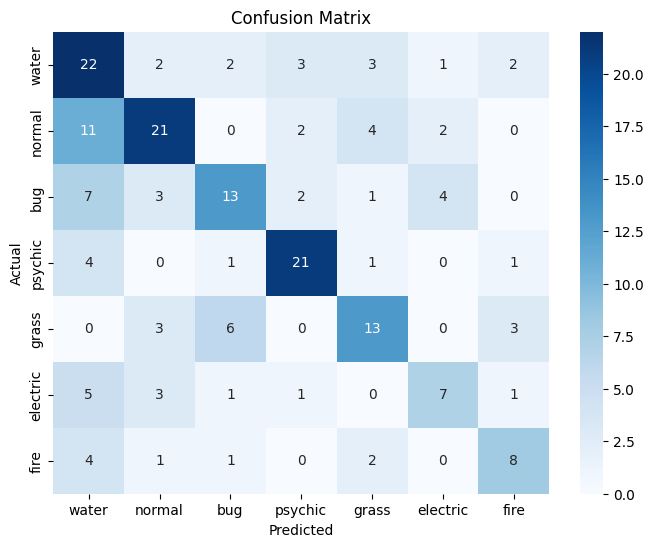

In [ ]:
result = KNN_hyperparameter_tuning(pca_train_data, train_labels, pca_test_data, test_labels, list_labels)
result["Pipeline"]="HSV-PCA-KNN"
results_all.append(result)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
4      rbf  scale    0.5729     0.5824  0.5634  0.552312
2     poly  scale    0.5417     0.5610  0.5468  0.531260
0   linear  scale    0.5156     0.5347  0.5275  0.509389
1   linear   auto    0.5156     0.5347  0.5275  0.509389
5      rbf   auto    0.4948     0.5448  0.4844  0.473897
3     poly   auto    0.4635     0.5129  0.4599  0.443373
7  sigmoid   auto    0.4635     0.5001  0.4599  0.444083
6  sigmoid  scale    0.3958     0.3820  0.4013  0.370006
rbf scale
Fully supervised results: Accuracy 0.5729, Precision 0.5824, Recall 0.5634


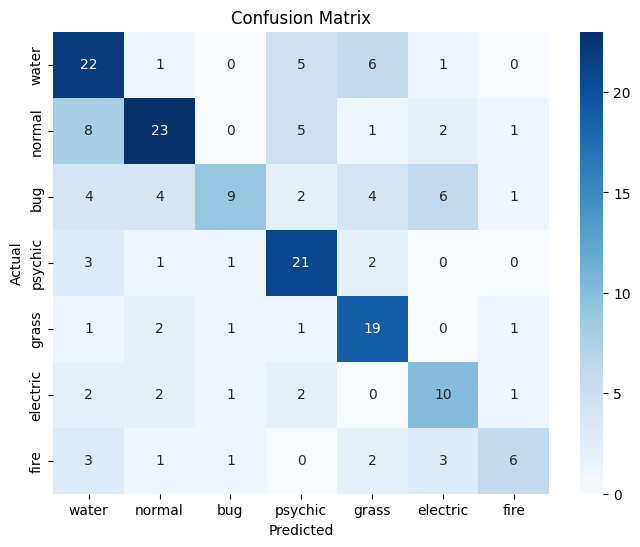

In [ ]:
result = SVM_hyperparameter_tuning(pca_train_data, train_labels, pca_test_data, test_labels, list_labels)
result["Pipeline"]="HSV-PCA-SVM"
results_all.append(result)

##### using scaled data

In [ ]:
train_data, test_data, train_labels, test_labels = scaler.fit_transform(X_train), scaler.fit_transform(X_test), y_train, y_test

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale    0.5625     0.5719  0.5714  0.551230
1   linear   auto    0.5625     0.5719  0.5714  0.551230
4      rbf  scale    0.5625     0.5820  0.5492  0.531445
2     poly  scale    0.5573     0.5999  0.5576  0.549177
3     poly   auto    0.5000     0.5445  0.4955  0.480589
7  sigmoid   auto    0.4948     0.5397  0.4919  0.475956
5      rbf   auto    0.4844     0.5261  0.4836  0.463182
6  sigmoid  scale    0.4062     0.3906  0.4083  0.379855
linear scale
Fully supervised results: Accuracy 0.5625, Precision 0.5719, Recall 0.5714


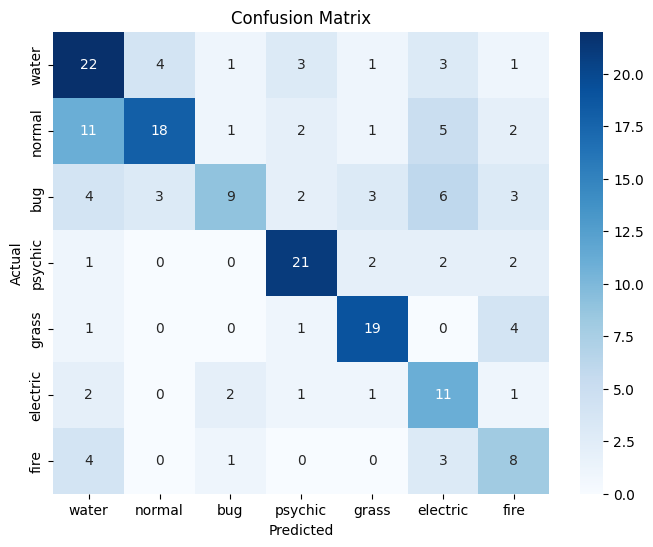

In [ ]:
result = SVM_hyperparameter_tuning(train_data, train_labels, test_data, test_labels, list_labels)

result["Pipeline"]="HSV-scaled-SVM"
results_all.append(result)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
17            5  distance     cosine    0.5156     0.5550  0.4945  0.508016
7             3  distance     cosine    0.5156     0.5390  0.4924  0.504543
27            7  distance     cosine    0.5000     0.5501  0.4792  0.493048
47           11  distance     cosine    0.4948     0.5776  0.4605  0.479670
37            9  distance     cosine    0.4896     0.5420  0.4533  0.464285
26            7  distance  manhattan    0.4844     0.5929  0.4387  0.444710
6             3  distance  manhattan    0.4635     0.4775  0.4452  0.450386
19            5  distance  minkowski    0.4583     0.5057  0.4279  0.442541
15            5  distance  euclidean    0.4583     0.5057  0.4279  0.442541
5             3  distance  euclidean    0.4479     0.4868  0.4276  0.442973
49           11  distance  minkowski    0.4479     0.5596  0.4181  0.428766
45           11  distance  euclidean    0.4479     0.5596  0.4181  0.428766
35          

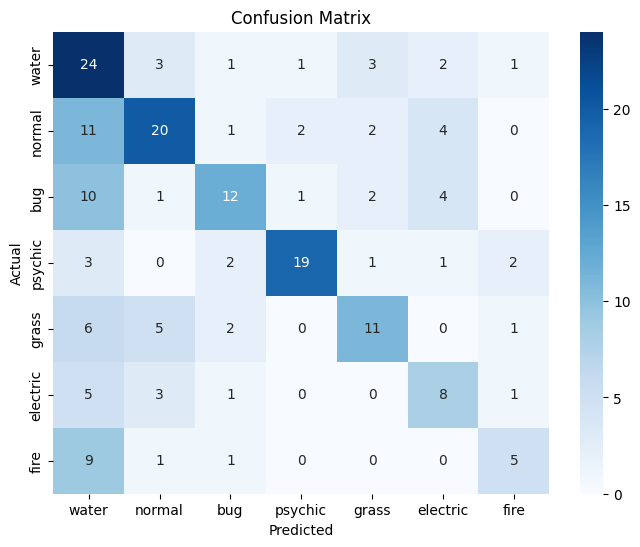

In [ ]:
result = KNN_hyperparameter_tuning(train_data, train_labels, test_data, test_labels, list_labels)

result["Pipeline"]="HSV-scaled-KNN"
results_all.append(result)

In [ ]:
res_df = pd.DataFrame(results_all)
res_df.sort_values(by='Pipeline', key=lambda x: x.str[-1], ascending=False, inplace=True)
res_df

,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
1,BW-KNN,NaN,NaN,0.442708,0.4117,0.3152,0.319431,3.0,distance,manhattan
2,BW-PCA-KNN,NaN,NaN,0.427083,0.4234,0.3368,0.339911,5.0,distance,euclidean
5,RGB-KNN,NaN,NaN,0.500000,0.5759,0.3544,0.353682,9.0,distance,manhattan
6,RGB-PCA-KNN,NaN,NaN,0.468750,0.5329,0.3871,0.395919,9.0,distance,euclidean
9,HSV-KNN,NaN,NaN,0.619792,0.5420,0.4440,0.461783,3.0,distance,manhattan
10,HSV-PCA-KNN,NaN,NaN,0.546875,0.4611,0.3357,0.330017,7.0,distance,cosine
13,HSV-scaled-KNN,NaN,NaN,0.515625,0.4749,0.3289,0.331847,5.0,distance,cosine
0,BW-SVM,rbf,scale,0.463500,0.4547,0.4232,0.424689,NaN,NaN,NaN
3,BW-PCA-SVM,rbf,scale,0.458300,0.4860,0.4227,0.423684,NaN,NaN,NaN
4,RGB-SVM,rbf,scale,0.536500,0.5636,0.4857,0.488807,NaN,NaN,NaN


###RESNET

In [ ]:
images_np.shape

(580, 50, 50, 4)

In [ ]:
labels.shape

(580,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images_np, labels, test_size=0.33, random_state=42)

train_data, test_data, train_labels, test_labels = (X_train), (X_test), np.array(y_train), np.array(y_test)

# Convert the input data to the appropriate data type
train_data = train_data.astype(np.float32)
test_data = test_data.astype(np.float32)

In [ ]:
train_data.shape

(388, 50, 50, 4)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Load the pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

resnet.conv1


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.7MB/s]


Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [ ]:
# Modify the Conv2d input channels to match the input data
resnet.conv1 = torch.nn.Conv2d(in_channels=50, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)

# Remove the fully connected layer at the end
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet[0:2]

Sequential(
  (0): Conv2d(50, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
resnet

Sequential(
  (0): Conv2d(50, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Co

In [ ]:
resnet.eval()

train_features = []
test_features = []
# Extract features for train data
with torch.no_grad():
    for sample in train_data:
        sample_tensor = torch.from_numpy(sample).unsqueeze(0)
        features = resnet(sample_tensor)
        features = torch.flatten(features, start_dim=1)
        train_features.append(features)

# Extract features for test data
with torch.no_grad():
    for sample in test_data:
        sample_tensor = torch.from_numpy(sample).unsqueeze(0)
        features = resnet(sample_tensor)
        features = torch.flatten(features, start_dim=1)
        test_features.append(features)

# Train SVM with Extracted Features
# Flatten the train features to a 2D array
train_features = torch.cat(train_features).numpy()

# Flatten the test features to a 2D array
test_features = torch.cat(test_features).numpy()

In [ ]:
train_features.shape

(388, 512)

    n_neighbors   weights     metric  Accuracy  Precision  Recall  F1-score
28            7  distance  chebyshev    0.3750     0.4172  0.3501  0.357654
18            5  distance  chebyshev    0.3698     0.3890  0.3497  0.352225
6             3  distance  manhattan    0.3698     0.3700  0.3599  0.360504
8             3  distance  chebyshev    0.3646     0.3628  0.3444  0.345827
19            5  distance  minkowski    0.3594     0.3486  0.3445  0.344411
17            5  distance     cosine    0.3594     0.3917  0.3530  0.364074
15            5  distance  euclidean    0.3594     0.3486  0.3445  0.344411
27            7  distance     cosine    0.3594     0.3875  0.3475  0.356860
16            5  distance  manhattan    0.3594     0.3577  0.3526  0.351117
7             3  distance     cosine    0.3594     0.3637  0.3475  0.351762
56           20  distance  manhattan    0.3542     0.3855  0.3196  0.325398
57           20  distance     cosine    0.3490     0.4262  0.3234  0.337974
38          

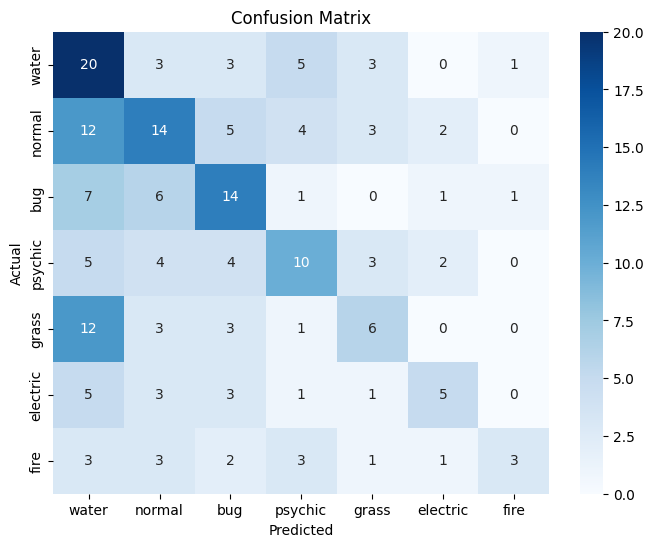

In [ ]:
result = KNN_hyperparameter_tuning(train_features, train_labels, test_features, test_labels, list_labels)

result["Pipeline"]="RESNET-KNN"
results_all.append(result)

    Kernel  Gamma  Accuracy  Precision  Recall  F1-score
0   linear  scale    0.3802     0.3680  0.3694  0.364761
1   linear   auto    0.3802     0.3680  0.3694  0.364761
2     poly  scale    0.3333     0.3530  0.3258  0.324677
5      rbf   auto    0.3333     0.3498  0.3182  0.318444
3     poly   auto    0.3125     0.3325  0.3060  0.301598
4      rbf  scale    0.2917     0.2829  0.2776  0.266539
6  sigmoid  scale    0.1354     0.2211  0.1071  0.089624
7  sigmoid   auto    0.1302     0.3047  0.1592  0.091647
linear scale
Fully supervised results: Accuracy 0.3802, Precision 0.368, Recall 0.3694


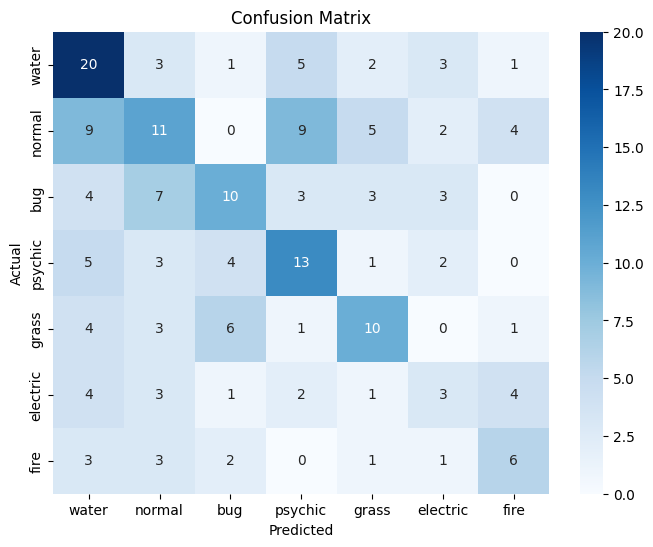

In [ ]:
result = SVM_hyperparameter_tuning(train_features, train_labels, test_features, test_labels, list_labels)

result["Pipeline"]="RESNET-SVM"
results_all.append(result)

###RESULTS

In [ ]:
print(TYPES_DICT)

print(set_csv)

res_df = pd.DataFrame(results_all)
res_df.sort_values(by='Pipeline', ascending=False, inplace=True)
res_df

{'water': 0, 'normal': 1, 'bug': 2, 'psychic': 3, 'grass': 4, 'electric': 5, 'fire': 6}
['pokemon_gen_1.csv', 'pokemon_gen_2.csv', 'pokemon_gen_3.csv', 'pokemon_gen_4.csv', 'pokemon_gen_5.csv']


,Pipeline,Kernel,Gamma,Accuracy,Precision,Recall,F1-score,n_neighbors,weights,metric
4,RGB-SVM,rbf,scale,0.536500,0.5636,0.4857,0.488807,NaN,NaN,NaN
7,RGB-PCA-SVM,rbf,scale,0.572900,0.5893,0.5221,0.531561,NaN,NaN,NaN
6,RGB-PCA-KNN,NaN,NaN,0.468750,0.5329,0.3871,0.395919,9.0,distance,euclidean
5,RGB-KNN,NaN,NaN,0.500000,0.5759,0.3544,0.353682,9.0,distance,manhattan
15,RESNET-SVM,linear,scale,0.380200,0.3680,0.3694,0.364761,NaN,NaN,NaN
14,RESNET-KNN,NaN,NaN,0.375000,0.3322,0.2893,0.294278,7.0,distance,chebyshev
12,HSV-scaled-SVM,linear,scale,0.562500,0.5719,0.5714,0.551230,NaN,NaN,NaN
13,HSV-scaled-KNN,NaN,NaN,0.515625,0.4749,0.3289,0.331847,5.0,distance,cosine
8,HSV-SVM,linear,scale,0.557300,0.5748,0.5379,0.547890,NaN,NaN,NaN
11,HSV-PCA-SVM,rbf,scale,0.572900,0.5824,0.5634,0.552312,NaN,NaN,NaN


In [ ]:
print(res_df.to_latex())

\begin{tabular}{llllrrrrrll}
\toprule
{} &        Pipeline &  Kernel &  Gamma &  Accuracy &  Precision &  Recall &  F1-score &  n\_neighbors &   weights &     metric \\
\midrule
4  &         RGB-SVM &     rbf &  scale &  0.536500 &     0.5636 &  0.4857 &  0.488807 &          NaN &       NaN &        NaN \\
7  &     RGB-PCA-SVM &     rbf &  scale &  0.572900 &     0.5893 &  0.5221 &  0.531561 &          NaN &       NaN &        NaN \\
6  &     RGB-PCA-KNN &     NaN &    NaN &  0.468750 &     0.5329 &  0.3871 &  0.395919 &          9.0 &  distance &  euclidean \\
5  &         RGB-KNN &     NaN &    NaN &  0.500000 &     0.5759 &  0.3544 &  0.353682 &          9.0 &  distance &  manhattan \\
15 &      RESNET-SVM &  linear &  scale &  0.380200 &     0.3680 &  0.3694 &  0.364761 &          NaN &       NaN &        NaN \\
14 &      RESNET-KNN &     NaN &    NaN &  0.375000 &     0.3322 &  0.2893 &  0.294278 &          7.0 &  distance &  chebyshev \\
12 &  HSV-scaled-SVM &  linear &  scale & 

<ipython-input-70-98a98ad7de15>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(res_df.to_latex())
